In [45]:
%matplotlib inline

import os
import h5py
import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.4.0


In [46]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/brdd/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    
import helper_functions as hlp
import function_read_data as rdat
import function_model_definition as md
import functions_gradcam as gc
import plot_function_gradcam as pgc

/tf/notebooks/brdd/xAI_stroke_3d


## Load Data

In [47]:
# Define the path + output path:
DATA_DIR = DIR + "data/"

version = "10Fold_sigmoid_V0" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
save_plot = False

# Define Model Version
model_version = 1

if version.startswith("10Fold"):
    WEIGHT_DIR = DIR + "weights/" + version + "/"
    OUTPUT_DIR = DIR + "pictures/" + version + "/"
    pic_save_name = "10Fold_ensembling" + version[6:]
    
elif version == "andrea":
    WEIGHT_DIR = DIR + "weights/andrea_split/"
    OUTPUT_DIR = DIR + "pictures/andrea_split/"
    pic_save_name = "andrea_split"

In [48]:
## load images and ids

if version == "andrea": ## for andrea
    with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
        # with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
        # both images are the same
            X_in = h5["X"][:]
            pat = h5["pat"][:]
            
    # load results
    path_results = DATA_DIR + "all_tab_results_andrea_split.csv" # andrea split
    
elif version.startswith("10Fold"): ## for 10 Fold       
    if version.endswith("V0") or version.endswith("sigmoid"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
        num_models = 5
    elif version.endswith("V1"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V1.csv", sep=",")
        num_models = 10
    elif version.endswith("V2") or version.endswith("V2f"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V2.csv", sep=",")
        num_models = 5
    elif version.endswith("V3"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V3.csv", sep=",")
        num_models = 5
    pat = id_tab["p_id"].to_numpy()
    X_in = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
    
    # load results
    path_results = DATA_DIR + "all_tab_results_" + version + "_M" + str(model_version) + ".csv" # 10 Fold

all_results = pd.read_csv(path_results, sep=",")
all_results = all_results.sort_values("p_idx")

In [49]:
## load patient data
PAT_CSV_DIR = "/tf/notebooks/hezo/stroke_zurich/data/baseline_data_zurich_prepared0.csv" 
pat_dat = pd.read_csv(PAT_CSV_DIR, sep=";")
pat_dat

,p_id,mrs3,age,sexm,nihss_baseline,mrs_before,stroke_beforey,tia_beforey,ich_beforey,rf_hypertoniay,rf_diabetesy,rf_hypercholesterolemiay,rf_smokery,rf_atrial_fibrillationy,rf_chdy,eventtia,iaty,ivty
0,101,1,"85,6",0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,NaN,NaN
1,102,1,"66,7",1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN,NaN
2,103,0,"29,2",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
3,104,0,83,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,NaN,NaN
4,105,6,"89,2",0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,540,2,80,0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0
514,541,0,19,1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1
515,542,1,68,1,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0
516,543,4,74,0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0


## Model

In [50]:
# define model
input_dim = (128, 128, 28, 1)

if "sigmoid" in version or "andrea_split" in version:
    last_activation = "sigmoid"
    output_dim = 1
    LOSS = "binary_crossentropy"
elif "softmax" in version:
    last_activation = "softmax"
    output_dim = 2
    LOSS = tf.keras.losses.categorical_crossentropy
    
if version.endswith("f"):
    layer_connection = "flatten"
else:
    layer_connection = "globalAveragePooling"

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


In [51]:
# Define Model Name
def generate_model_name(which_split, model_nr, model_version = model_version, path = WEIGHT_DIR):
    if layer_connection == "globalAveragePooling":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_avg_layer_paper_model_" + last_activation + "_activation_"  + str(model_version) + str(model_nr) + ".h5")
    elif layer_connection == "flatten":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_flat_layer_paper_model_" + last_activation + "_activation_" + str(model_version) + str(model_nr) + ".h5")

In [52]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

# Oclusion Functions

In [53]:
from collections import defaultdict

def iter_occlusion(volume, size=4, stride = None):
  # volume: np array in shape 128, 128, 64, 1

  occlusion_center = np.full((size[0], size[1], size[2], 1), [0.5], np.float32)

  for x in range(0, volume.shape[0]-size[0]+1, stride):
    for y in range(0, volume.shape[1]-size[1]+1, stride):
      for z in range(0, volume.shape[2]-size[2]+1, stride):
        tmp = volume.copy()

        tmp[x:x + size[0], y:y + size[1], z:z + size[2]] = occlusion_center

        yield x, y, z, tmp
  
def volume_occlusion(volume, correct_class, occlusion_size, 
                     model = model_3d,
                     occlusion_stride = None):

  print('occluding...')
  
  volume = volume.reshape(128,128,28,1)
  
  if len(occlusion_size) == 1:
    occlusion_size = np.array([occlusion_size, occlusion_size, occlusion_size])
  elif len(occlusion_size) != 3:
    raise ValueError('occluson_size must be a scalar or a 3 element array')

  if occlusion_stride is None:
    occlusion_stride = np.min(occlusion_size)
  elif any(occlusion_stride > occlusion_size):
    raise ValueError('stride must be smaller or equal size')
  
  if any(occlusion_stride == occlusion_size):
    if (not (volume.shape[0] / occlusion_size)[0].is_integer() or
        not (volume.shape[1] / occlusion_size)[1].is_integer() or 
        not (volume.shape[2] / occlusion_size)[2].is_integer()):
      
      raise ValueError('size does not work with this volume')
  elif any(occlusion_stride != occlusion_size):
    if (((volume.shape[0]-occlusion_size[0]) % occlusion_stride) != 0 or 
        ((volume.shape[1]-occlusion_size[1]) % occlusion_stride) != 0 or
        ((volume.shape[2]-occlusion_size[2]) % occlusion_stride) != 0):
      
      raise ValueError('shape and size do not match')

  # num_occlusion =  int(np.prod(((np.array(volume.shape[0:3]) - occlusion_size) / occlusion_stride) + 1))

  heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
  heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

  counters = defaultdict(int)

  for n, (x, y, z, vol_float) in tqdm.tqdm(enumerate(iter_occlusion(volume, size = occlusion_size, stride = occlusion_stride))):
      X = vol_float.reshape(1, volume.shape[0], volume.shape[1], volume.shape[2], 1)
      out = model.predict(X)

      heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[0]
      heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

      counters[np.argmax(out)] += 1

  print("\n")
  print("calculating heatmap...")

  heatmap = heatmap_prob_sum/heatmap_occ_n
  
  print("\n done")

  return heatmap#, class_pixels



In [68]:
# occlusion_size = occ_size
# occlusion_stride = occ_stride
# volume = res_images
# volume = volume.reshape(128,128,28,1)

# XX = []
# for n, (x, y, z, vol_float) in tqdm.tqdm(enumerate(iter_occlusion(volume, size = occlusion_size, stride = occlusion_stride))):
#       XX.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
# X = np.array(XX)
      

675it [00:00, 1768.49it/s]


In [73]:
# model = cnn
# model.predict(X)

array([[0.0107294 ],
       [0.01041572],
       [0.01049491],
       [0.01079769],
       [0.01040121],
       [0.01049452],
       [0.01082493],
       [0.01037712],
       [0.01049405],
       [0.01089845],
       [0.01046012],
       [0.01049307],
       [0.01088761],
       [0.01041461],
       [0.01050762],
       [0.01097969],
       [0.01041643],
       [0.0105759 ],
       [0.01107359],
       [0.01049667],
       [0.01061454],
       [0.01124608],
       [0.01068179],
       [0.01066524],
       [0.01122699],
       [0.01053504],
       [0.01064903],
       [0.01094117],
       [0.01037387],
       [0.01060669],
       [0.0108729 ],
       [0.01035999],
       [0.01053947],
       [0.01093875],
       [0.01045155],
       [0.01052512],
       [0.01086472],
       [0.01040249],
       [0.01049932],
       [0.01083124],
       [0.01039281],
       [0.01047794],
       [0.01073894],
       [0.01037397],
       [0.01048555],
       [0.01078057],
       [0.01042392],
       [0.010

In [54]:
(res_table, res_images, res_model_names) = gc.get_img_and_models(
        [1], results = all_results, pats = pat, imgs = X_in, 
        gen_model_name = generate_model_name,
        num_models = num_models)

In [55]:
# occlusion
occ_size = (16, 16, 12)
occ_stride = 8
print("number of occlusions: ", int(np.prod(((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)))
print("number of occlusions per axis: ", ((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)
print((np.asarray(res_images.shape[1:4]) - occ_size) % occ_stride) # all must be zero
print(all(np.array(occ_size) > occ_stride)) # must be true
print(np.array(res_images.shape[1:4]) / occ_size) # if all same, then same ratio of occ_size to image size



number of occlusions:  675
number of occlusions per axis:  [15. 15.  3.]
[0 0 0]
True
[8.         8.         2.33333333]


In [56]:
cnn = model_3d
cnn.load_weights(res_model_names[0][0])
res_table["y_pred_class"][0]

0

In [57]:
cnn.predict(res_images)[0].shape

(1,)

In [58]:

(heatmap) =  volume_occlusion(
    volume = res_images, 
    correct_class = res_table["y_pred_class"][0], 
    occlusion_size = np.array(occ_size), 
    model = cnn,
    occlusion_stride = occ_stride)

occluding...


675it [00:22, 30.08it/s]



calculating heatmap...

 done


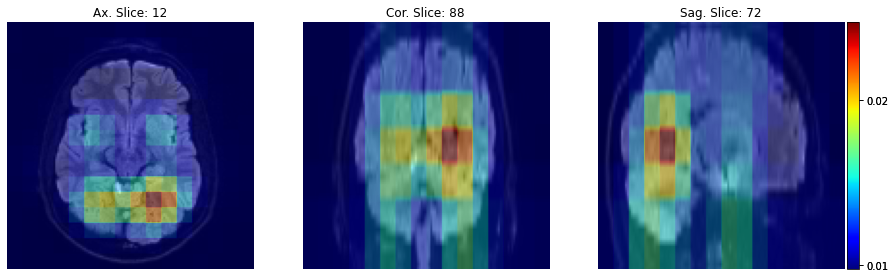

In [59]:
res_images = res_images.reshape(128,128,28)
heatmap = heatmap.reshape(128, 128, 28)

pgc.plot_gradcam(res_images, heatmap,
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

# Occlusion Slider

In [60]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, Layout, AppLayout
from IPython.display import display
from termcolor import colored
import ipywidgets as widgets

from importlib import reload
reload(pgc)
reload(gc)

def occlusion_interactive_plot(p_id, occ_size, occ_stride, 
                               pred_hm_only=True, cnn = model_3d):
    p_ids = [p_id]
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in, 
        gen_model_name = generate_model_name,
        num_models = num_models)
    
    print("patient id: ", res_table.p_id[0])
    print("age: ", pat_dat[pat_dat["p_id"] == res_table.p_id[0]]["age"].values[0])
    print("true mrs: ", res_table.mrs[0])
    print("true class: ", res_table.unfavorable[0])
    print(colored("pred class: "+str(res_table.y_pred_class[0]), 
                'green' if res_table["pred_correct"][0] == True else 'red'))
    print("pred prob (class 1): ", res_table.y_pred_trafo_avg[0])
    print("pred uncertainty: ", res_table.y_pred_unc[0])
    # print("heatmap unc. last layer: ", res_table.y_pred_unc[0])
    
    ## Generate heatmap
    if pred_hm_only:
        invert_hm = "all" if res_table.y_pred_class[0] == 0 else "none"
        gcpp_hm = "last"
        cmap = "jet"
        hm_positive=True
    else:
        invert_hm = "none"
        gcpp_hm = "none"
        cmap = "bwr"
        hm_positive=False
            
    cnn.load_weights(res_model_names[0][0])        
    
    heatmap =  volume_occlusion(
        volume = res_images, 
        correct_class = res_table["y_pred_class"][0], 
        occlusion_size = np.array(occ_size), 
        model = cnn,
        occlusion_stride = occ_stride)
    
    res_images = np.reshape(res_images, (128,128,28,1))
    heatmap = np.reshape(heatmap, (128,128,28,1))

    slices = np.unravel_index(heatmap.argmax(), heatmap.shape)
    print("max slices:", (slices[2], slices[0], slices[1]))
    
    ## Plot Heatmap Average
    pgc.plot_gradcam(res_images, heatmap,
                version = "overlay",
                mode = "avg",
                hm_colormap=cmap,
                hm_positive=hm_positive,
                colorbar=True)

    ## Plot Heatmap Slider
    def slicer(axi_slider, cor_slider, sag_slider):
        pgc.plot_gradcam(res_images, heatmap,
                version = "overlay",
                mode = "def",
                slices = (cor_slider,sag_slider,axi_slider),
                hm_colormap=cmap,
                hm_positive=hm_positive,
                colorbar=True)
        pgc.plot_gradcam(res_images, heatmap,
                version = "original",
                mode = "def",
                slices=(cor_slider,sag_slider,axi_slider),
                hm_colormap=cmap,
                hm_positive=hm_positive,
                slice_line=True)

    w=interactive(
        slicer, 
        axi_slider=widgets.IntSlider(value=slices[2],min=0,max=27,step=1), 
        cor_slider=widgets.IntSlider(value=slices[0],min=0,max=127,step=1), 
        sag_slider=widgets.IntSlider(value=slices[1],min=0,max=127,step=1))

    slider_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', align_items='center',
                        width='9.2in')
    images_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', align_items='center',
                        width='15', height='15')

    display(VBox([
        HBox([w.children[0],w.children[1], w.children[2]], layout=slider_layout),
        HBox([w.children[3]], layout=images_layout)
    ]))      
    w.update()

patient id:  145
age:  65,6
true mrs:  0.0
true class:  0
pred class: 0
pred prob (class 1):  0.04076397
pred uncertainty:  0.053144198
occluding...


24it [00:00, 30.44it/s]

675it [00:21, 30.83it/s]




calculating heatmap...

 done
max slices: (12, 80, 72)


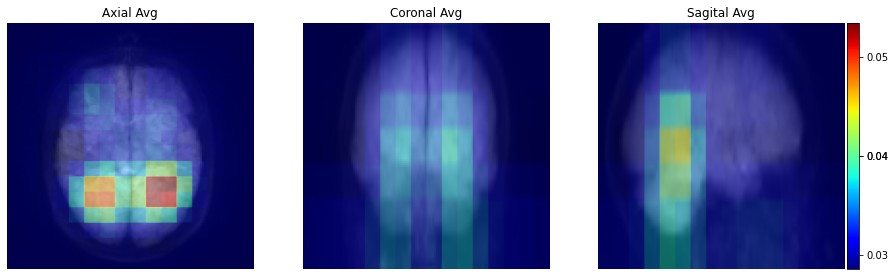

In [61]:
occlusion_interactive_plot(145,
                           occ_size = occ_size, occ_stride = occ_stride,
                           pred_hm_only=True)
